In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from bayes_opt import BayesianOptimization

from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import log_loss

import pandas as pd
import numpy as np
import warnings

plt.style.use('ggplot')
warnings.filterwarnings('ignore')
seed = 101 # Lucky seed

Load and inspect San Francisco Crime Classification dataset.

In [2]:
df = pd.read_csv('./data/train.csv')
df.head()

,Dates,Category,Descript,DayOfWeek,PdDistrict,Resolution,Address,X,Y
0,2015-05-13 23:53:00,WARRANTS,WARRANT ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",OAK ST / LAGUNA ST,-122.425892,37.774599
1,2015-05-13 23:53:00,OTHER OFFENSES,TRAFFIC VIOLATION ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",OAK ST / LAGUNA ST,-122.425892,37.774599
2,2015-05-13 23:33:00,OTHER OFFENSES,TRAFFIC VIOLATION ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",VANNESS AV / GREENWICH ST,-122.424363,37.800414
3,2015-05-13 23:30:00,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Wednesday,NORTHERN,NONE,1500 Block of LOMBARD ST,-122.426995,37.800873
4,2015-05-13 23:30:00,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Wednesday,PARK,NONE,100 Block of BRODERICK ST,-122.438738,37.771541


Numerically encode target and categorical variables.

In [3]:
cat_feats = ['Category', 'Descript', 'DayOfWeek', 'PdDistrict', 'Resolution']
cat_dicts = {}
for feat in cat_feats:
    cat_dicts[feat] = {k:v for (v,k) in enumerate(df[feat].value_counts().index)}

In [4]:
for feat in cat_dicts.keys():
    df[feat] = df[feat].map(cat_dicts[feat])
df.head()

,Dates,Category,Descript,DayOfWeek,PdDistrict,Resolution,Address,X,Y
0,2015-05-13 23:53:00,7,5,1,2,1,OAK ST / LAGUNA ST,-122.425892,37.774599
1,2015-05-13 23:53:00,1,44,1,2,1,OAK ST / LAGUNA ST,-122.425892,37.774599
2,2015-05-13 23:33:00,1,44,1,2,1,VANNESS AV / GREENWICH ST,-122.424363,37.800414
3,2015-05-13 23:30:00,0,0,1,2,0,1500 Block of LOMBARD ST,-122.426995,37.800873
4,2015-05-13 23:30:00,0,0,1,8,0,100 Block of BRODERICK ST,-122.438738,37.771541


Grab data and split into train/test sets.

In [5]:
X = df[['Descript', 'DayOfWeek', 'PdDistrict', 'Resolution', 'X', 'Y']].values
y = df['Category'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=seed)

Define target function and instantiate Bayesian Optimization instance.

In [6]:
def target(**params):
    n_estimators = int(params['n_estimators'])
    max_depth = int(params['max_depth'])
    min_samples_split = int(params['min_samples_split'])
    class_weight = int(params['class_weight'])
    class_weight_dict = {0:None, 1:'balanced'}
    model = RandomForestClassifier(n_estimators=n_estimators,
                                   max_depth=max_depth,
                                   min_samples_split=min_samples_split,
                                   class_weight=class_weight_dict[class_weight],
                                   n_jobs=-1, random_state=seed)
    scores = cross_val_score(model, X_train, y_train, scoring='neg_log_loss', cv=3)
    return scores.mean()

In [7]:
params = {'n_estimators':(10,200),
          'max_depth':(1,20),
          'min_samples_split':(2,200),
          'class_weight':(0,1.99)}
bo = BayesianOptimization(target, params, random_state=seed)
bo.gp.set_params(alpha=1e-8)
bo.maximize(init_points=5, n_iter=10, acq='ucb', kappa=5)

Initialization
---------------------------------------------------------------------------------------------------
 Step |   Time |      Value |   class_weight |   max_depth |   min_samples_split |   n_estimators | 
    1 | 01m45s |   -1.21099 |         0.4624 |     16.8440 |            111.7371 |       108.1157 | 
    2 | 01m10s |   -1.95048 |         0.1663 |      6.8324 |             71.7221 |       118.4268 | 
    3 | 00m21s |   -1.25895 |         1.2011 |     17.9786 |             38.0147 |        15.4101 | 
    4 | 00m46s |   -1.56642 |         1.4507 |     14.7093 |            157.5491 |        42.5891 | 
    5 | 01m10s |   -2.16718 |         0.5497 |      4.6088 |            193.1657 |       140.2026 | 
Bayesian Optimization
---------------------------------------------------------------------------------------------------
 Step |   Time |      Value |   class_weight |   max_depth |   min_samples_split |   n_estimators | 
    6 | 04m18s |   -0.84397 |         1.9900 |     20.00

In [8]:
bo.res['max']

{'max_params': {'class_weight': 1.99,
  'max_depth': 20.0,
  'min_samples_split': 2.0,
  'n_estimators': 81.564821658051315},
 'max_val': -0.84298359447112736}

Retrain model and score on test set.

In [9]:
model = RandomForestClassifier(n_estimators=200, max_depth=20, min_samples_split=2, class_weight='balanced', n_jobs=-1)
model.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=20, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=200, n_jobs=-1, oob_score=False,
            random_state=None, verbose=0, warm_start=False)

In [10]:
labels = list(cat_dicts['Category'].values())
log_loss(y_test, model.predict_proba(X_test), labels=labels)

0.81695419198287644

Visualize hyperparameter space by looking at marginal responses.

In [15]:
def get_marginal_response(hyperparam_name):
    idx_dict = {'n_estimators':(0, np.linspace(10,200,100)),
                'max_depth':(1, np.linspace(1,20,100)),
                'min_samples_split':(2, np.linspace(2,200,100)),
                'class_weight':(3, np.linspace(0,2,100))}
    # Create input data block 
    X_all = np.ones(shape=(100,4))
    X_all[:,0] = 81*X_all[:,0]
    X_all[:,1] = 20*X_all[:,1]
    X_all[:,2] = 2*X_all[:,2]
    X_all[:,3] = 1.99*X_all[:,2]
    # Replace desired hyperparameter range
    idx, val = idx_dict[hyperparam_name]
    X_all[:,idx] = val
    # Predict and return range/predictions
    mu, std = bo.gp.predict(X_all, return_std=True)
    return X_all[:,idx], mu.ravel(), std

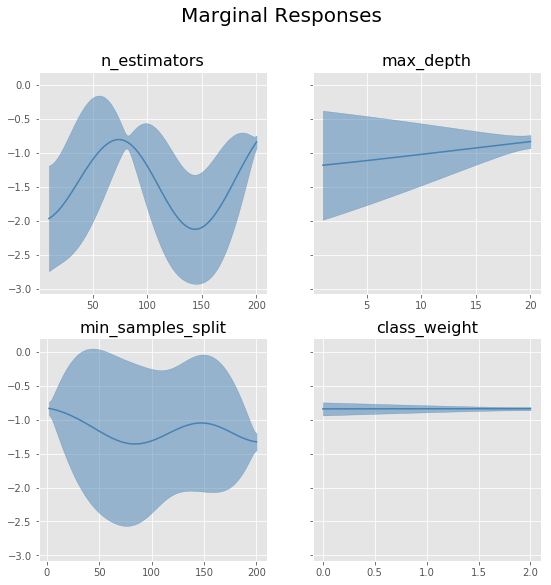

In [16]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(9,9), sharey=True)
for i, hyperparam_name in enumerate(['n_estimators', 'max_depth', 'min_samples_split', 'class_weight']):
    x, mu, std = get_marginal_response(hyperparam_name)
    ax.ravel()[i].plot(x, mu, color='steelblue', label='Prediction')
    ax.ravel()[i].fill_between(x, mu-1.96*std, mu+1.96*std, alpha=0.5, color='steelblue')
    ax.ravel()[i].set_title(hyperparam_name, fontsize=16)
fig.suptitle('Marginal Responses', fontsize=20)
plt.show()